In [35]:
import matplotlib.pyplot as plt
import numpy as np
import imageIO.readwrite as IORW
import imageProcessing.pixelops as IPPixelOps
import imageProcessing.smoothing as IPSmooth

import math
from tqdm import tqdm

from matplotlib.patches import Circle

In [181]:
filename_left_image = r"images\panoramaStitching\bryce_left_02.png"
(image_width, image_height, px_array_left_original)  = IORW.readRGBImageAndConvertToGreyscalePixelArray(filename_left_image)
px_array_left = IPSmooth.computeGaussianAveraging3x3(px_array_left_original, image_width, image_height)
px_array_left = IPPixelOps.scaleTo0And255AndQuantize(px_array_left, image_width, image_height)
im = np.float64(px_array_left)

read image width=1000, height=750
before scaling, min value = 0, max value = 250.36413341989999


In [183]:
def filter(im, kernel):
    """Performs a 2d sqaure convolution on an image using ignore border padding"""
    rows, cols = np.shape(im)

    kernel_width, kernel_height = np.shape(kernel)
    k_radius_w = (kernel_width - 1)//2 #represents the distance from kernel center to right/left edge
    k_radius_h = (kernel_height - 1)//2 #represents the distance from kernel center to right/left edge
    
    padded_im = np.pad(im, ((k_radius_w, k_radius_w), (k_radius_h, k_radius_h)), mode='reflect')
    new_im = np.zeros_like(im)


    for i in range(k_radius_w, rows + k_radius_w):
        for j in range(k_radius_h, cols + k_radius_h):
            new_im[i - k_radius_w, j - k_radius_h]  = np.sum(np.multiply(kernel, padded_im[i - k_radius_w:i + k_radius_w + 1, 
                                                         j - k_radius_h:j + k_radius_h + 1]))

    return new_im

def gaussian_filter(im, width=None, sigma=1):
    size = int(2 * np.ceil(3 * sigma) + 1)
    size = size + 1 if size % 2 == 0 else size
    gaussian_kernal = np.zeros((size, size))
    k_radius = (size - 1)//2

    for x in range(-k_radius, k_radius + 1):
        for y in range(-k_radius, k_radius + 1): 
            gaussian_kernal[k_radius + x, k_radius + y] = (1/(2 * math.pi * sigma ** 2)) * math.e ** -((x**2 + y**2) / (2 * sigma**2))

    gaussian_kernal = gaussian_kernal / np.sum(gaussian_kernal)
    return filter(im, gaussian_kernal)

def DoG_nms(im, window_size, height=3):
    x,y,z = im.shape
    im = np.abs(im)
    half_win = window_size//2
    half_height = height//2
    for z_layer in range(half_height, z-half_height):
        for i in range(half_win, x - half_win):
            for j in range(half_win, y - half_win):
                cube = im[(i-half_win):(i+half_win+1), (j-half_win):(j+half_win+1), (z_layer-half_height):(z_layer+half_height+1)]
                im[(i-half_win):(i+half_win+1), (j-half_win):(j+half_win+1), (z_layer-half_height):(z_layer+half_height+1)] = cube * (cube == np.max(cube))
    
    return im

In [184]:
import cv2 as cv

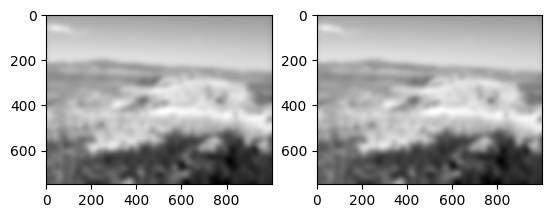

In [185]:
test = gaussian_filter(im, width=21, sigma=12)
opencv_test = cv.GaussianBlur(im, (0,0), 12)

fig1, axs1 = plt.subplots(1, 2)

axs1[0].imshow(test,cmap="gray")
axs1[1].imshow(opencv_test,cmap="gray")

## Calculate the values of k for which you will make the image pyramid

In [186]:
sigma = 2
k = 1.6

iterations = 10

In [187]:
sigma_list = [k*i*sigma for i in range(1,iterations)]
sigma_list

[3.2,
 6.4,
 9.600000000000001,
 12.8,
 16.0,
 19.200000000000003,
 22.400000000000002,
 25.6,
 28.8]

In [188]:
dog_pyramid = np.empty(im.shape + (len(sigma_list)-1,), dtype="float64")

In [189]:
previous = gaussian_filter(im, 5, sigma_list[0])
for i, sig in enumerate(sigma_list[1:]):
    current = gaussian_filter(im, 5, sig)
    dog_pyramid[..., i] = previous - current
    previous = current

normalisation_factor = 1 / (k - 1)
dog_pyramid *= normalisation_factor

In [171]:
dog_pyramid.shape

(750, 1000, 8)

In [190]:
maxima = DoG_nms(dog_pyramid, 13)
np.sum(maxima)

37771.736546049266

In [191]:
score_feature_list = [(score, coords[0], coords[1], coords[2]) for coords, score in list(np.ndenumerate(maxima)) if score != 0]
score_feature_list.sort(reverse=True, key=lambda x: x[0]) #Lambda function explicitly tells it to sort on the first element even though I think it does this automatically

final_features = score_feature_list[:1000]

feature_list = [(row, col, sigma_list[sig+1]) for (_,col, row, sig) in final_features]
print("There were originally", len(score_feature_list), "blobs")

There were originally 3534 blobs


100%|██████████| 1000/1000 [00:03<00:00, 294.98it/s]


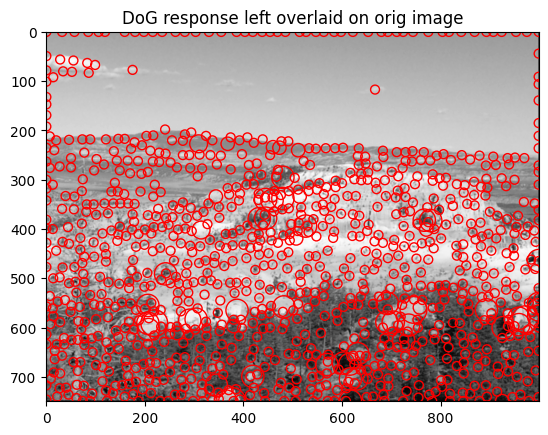

In [192]:
fig1, axs1 = plt.subplots()

axs1.set_title('DoG response left overlaid on orig image')
axs1.imshow(px_array_left, cmap='gray')

# plot a red point in the center of each image
#circle = Circle((image_width/2, image_height/2), 3.5, color='r')
#axs1[0].add_patch(circle)

#circle = Circle((image_width/2, image_height/2), 3.5, color='r')
#axs1[1].add_patch(circle)

#Plot corners points on image
for corner_point in tqdm(feature_list):
    circle = Circle(corner_point[:2], corner_point[2] * 2**0.5, color='red', linewidth=1, fill=False)
    axs1.add_patch(circle)
